In [ ]:
# CONDUCT SOME FORM OF SIMILARITY COMPARISON.
#1 ideas: for each point on the wave, find its relative position to all other points. points_amplitude/max-min * 

# Pooling shards into a single tensor

In [1]:
import os
import torch
from pathlib import Path
import glob
from tqdm.notebook import tqdm

def load_and_concat_shards(dataset_path, mode='train'):
    """
    Loads and concatenates all EEG and MAG shards from the specified dataset path and mode.
    
    Args:
        dataset_path (str): Path to the dataset root directory
        mode (str): One of 'train', 'val', or 'test'
    
    Returns:
        tuple: (concatenated_eeg, concatenated_mag) tensors
    """
    # Initialize lists to store tensors
    eeg_tensors = []
    mag_tensors = []
    
    # Get all subject folders in the specified mode
    mode_path = Path(dataset_path) / mode
    subject_folders = sorted([f for f in mode_path.iterdir() if f.is_dir()])
    
    print(f"Loading {mode} data from {len(subject_folders)} subjects...")
    
    # Iterate through each subject folder
    for subject_folder in tqdm(subject_folders, desc="Loading subjects"):
        # Load EEG shards
        eeg_shard_folder = subject_folder / "EEG_shards"
        if eeg_shard_folder.exists():
            eeg_files = sorted(eeg_shard_folder.glob("*.pt"))
            for eeg_file in eeg_files:
                eeg_tensor = torch.load(eeg_file)
                eeg_tensors.append(eeg_tensor)
        
        # Load MAG shards
        mag_shard_folder = subject_folder / "MAG_shards"
        if mag_shard_folder.exists():
            mag_files = sorted(mag_shard_folder.glob("*.pt"))
            for mag_file in mag_files:
                mag_tensor = torch.load(mag_file)
                mag_tensors.append(mag_tensor)
    
    # Concatenate all tensors
    if eeg_tensors:
        concatenated_eeg = torch.cat(eeg_tensors, dim=2)  # Concatenate along windows dimension
    else:
        concatenated_eeg = None
        
    if mag_tensors:
        concatenated_mag = torch.cat(mag_tensors, dim=2)  # Concatenate along windows dimension
    else:
        concatenated_mag = None
    
    return concatenated_eeg, concatenated_mag

# Load and concatenate the data
dataset_path = "/srv/openfmri"  # Adjust this path as needed
eeg_data, mag_data = load_and_concat_shards(dataset_path, mode='train')

# Print information about the tensors
print("\nData shapes:")
if eeg_data is not None:
    print(f"EEG data: {eeg_data.shape}")
    print(f"  - {eeg_data.shape[0]} channels")
    print(f"  - {eeg_data.shape[1]} timepoints per window")
    print(f"  - {eeg_data.shape[2]} total windows")
    print(f"  - dtype: {eeg_data.dtype}")
else:
    print("No EEG data found")

if mag_data is not None:
    print(f"\nMAG data: {mag_data.shape}")
    print(f"  - {mag_data.shape[0]} channels")
    print(f"  - {mag_data.shape[1]} timepoints per window")
    print(f"  - {mag_data.shape[2]} total windows")
    print(f"  - dtype: {mag_data.dtype}")
else:
    print("No MAG data found")

# Optional: Print some basic statistics
if eeg_data is not None:
    print("\nEEG Statistics:")
    print(f"Mean: {eeg_data.float().mean():.3f}")
    print(f"Std: {eeg_data.float().std():.3f}")
    print(f"Min: {eeg_data.float().min():.3f}")
    print(f"Max: {eeg_data.float().max():.3f}")

if mag_data is not None:
    print("\nMAG Statistics:")
    print(f"Mean: {mag_data.float().mean():.3f}")
    print(f"Std: {mag_data.float().std():.3f}")
    print(f"Min: {mag_data.float().min():.3f}")
    print(f"Max: {mag_data.float().max():.3f}")

Loading train data from 11 subjects...


Loading subjects:   0%|          | 0/11 [00:00<?, ?it/s]

/tmp/ipykernel_538762/4224369637.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  eeg_tensor = torch.load(eeg_file)
/tmp/ipykernel_538762/4224369637.py:43: FutureWarning


Data shapes:
EEG data: torch.Size([74, 275, 25706])
  - 74 channels
  - 275 timepoints per window
  - 25706 total windows
  - dtype: torch.float16

MAG data: torch.Size([102, 275, 25706])
  - 102 channels
  - 275 timepoints per window
  - 25706 total windows
  - dtype: torch.float16

EEG Statistics:
Mean: 0.001
Std: 1.049
Min: -122.562
Max: 77.312

MAG Statistics:
Mean: -0.000
Std: 0.060
Min: -5.055
Max: 4.867


# Plotting a mean-pooled spectogramm (eeg channel 13, mag 65) 

Concatenating up to 50 windows for EEG channel 13 and MAG channel 65.


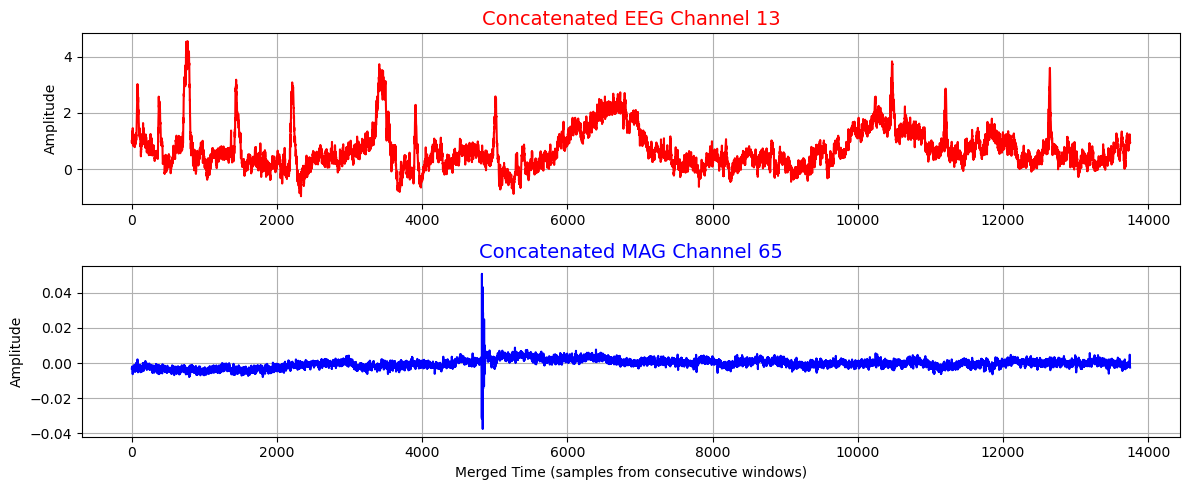

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------
# Parameters (adjust as needed)
# ---------------------------
eeg_channel_index = 13   # "013" EEG electrode index
mag_channel_index = 65   # "0621" MAG electrode index
num_windows_to_concatenate = 50  # How many windows (runs) to concatenate
# ---------------------------

# Safety check: ensure eeg_data and mag_data exist
if eeg_data is None or mag_data is None:
    print("EEG or MAG data not found. Please ensure both are loaded.")
else:
    total_windows_eeg = eeg_data.shape[2]
    total_windows_mag = mag_data.shape[2]
    
    # Determine how many windows we can pull without exceeding either array
    max_windows = min(num_windows_to_concatenate, total_windows_eeg, total_windows_mag)
    
    print(f"Concatenating up to {max_windows} windows for EEG channel {eeg_channel_index} and MAG channel {mag_channel_index}.")
    
    # ---------------------------------------------------------------------
    # Reshape EEG data (channel = eeg_channel_index) into a single 1D time series
    #   shape(eeg_data) => [num_eeg_channels, time_points_per_window, total_windows]
    #   so  eeg_slice   => [time_points_per_window, max_windows]
    #   then reshape to [time_points_per_window*max_windows]
    # ---------------------------------------------------------------------
    eeg_slice = eeg_data[eeg_channel_index, :, :max_windows].float().cpu().numpy()
    # Transpose to shape (max_windows, time_points_per_window), then flatten
    eeg_concat = eeg_slice.T.reshape(-1)
    
    # ---------------------------------------------------------------------
    # Similarly, reshape MAG data (channel = mag_channel_index) into a single 1D time series
    # ---------------------------------------------------------------------
    mag_slice = mag_data[mag_channel_index, :, :max_windows].float().cpu().numpy()
    mag_concat = mag_slice.T.reshape(-1)

    # ---------------------------------------------------------------------
    # Plot the concatenated EEG on one subplot, and MAG on another
    # ---------------------------------------------------------------------
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 5), sharex=False)

    # EEG plot
    axs[0].plot(eeg_concat, color='red')
    axs[0].set_title(f"Concatenated EEG Channel {eeg_channel_index}", color='red', fontsize=14)
    axs[0].set_ylabel("Amplitude")
    axs[0].grid(True)

    # MAG plot
    axs[1].plot(mag_concat, color='blue')
    axs[1].set_title(f"Concatenated MAG Channel {mag_channel_index}", color='blue', fontsize=14)
    axs[1].set_xlabel("Merged Time (samples from consecutive windows)")
    axs[1].set_ylabel("Amplitude")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

# Plot non-mean pooled (original) spectograms for the same  (eeg channel 13, mag 65) 

Opening raw data file /srv/openfmri/train/sub-01/run_05.fif...
Isotrak not found
    Range : 0 ... 111099 =      0.000 ...   504.995 secs
Ready.
Reading 0 ... 111099  =      0.000 ...   504.995 secs...


/tmp/ipykernel_450777/3123012312.py:18: RuntimeWarning: This filename (/srv/openfmri/train/sub-01/run_05.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_path, preload=True)


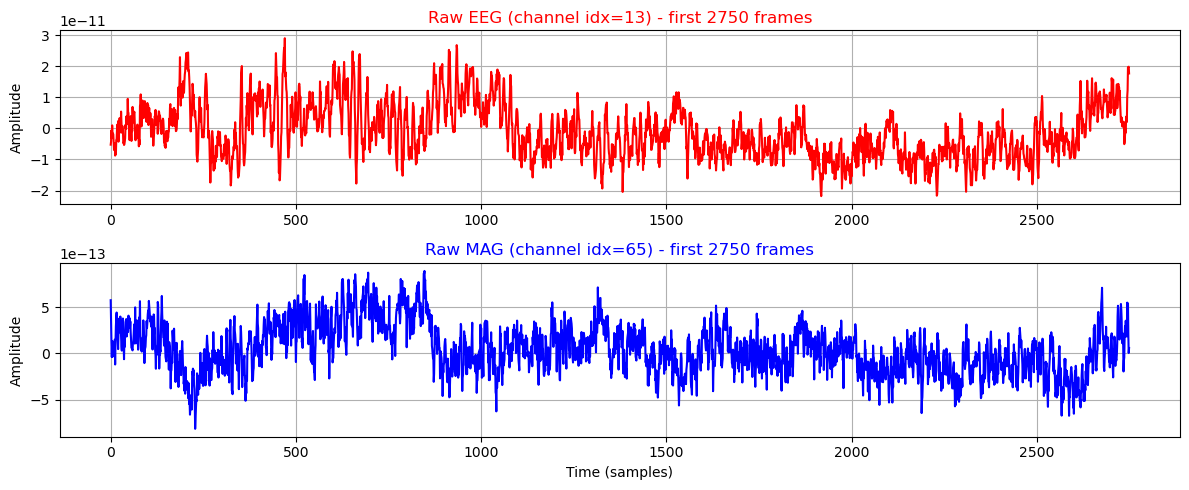

In [3]:
import os
import mne
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------
# Parameters (adjust as needed)
# ---------------------------
rang = 6
fif_path = "/srv/openfmri/train/sub-01/run_05.fif"  # Replace with the actual path
eeg_channel_index = 13    # "013" EEG electrode index
mag_channel_index = 65    # "0621" MAG electrode index
num_frames_to_plot = 2750 # Number of frames from the original recording
# ---------------------------

# Load the raw data from the original .fif file
try:
    raw = mne.io.read_raw_fif(fif_path, preload=True)
except Exception as e:
    print(f"Failed to read {fif_path}: {e}")
    raw = None

if raw is not None:
    # Extract the data as a NumPy array: shape (n_channels, n_times)
    original_data = raw.get_data()

    n_channels, n_times = original_data.shape
    
    # Safety check before slicing
    if eeg_channel_index >= n_channels or mag_channel_index >= n_channels:
        raise IndexError("Channel index is out of range for the provided FIF file.")

    if num_frames_to_plot > n_times:
        raise ValueError(f"Requested {num_frames_to_plot} frames but file only has {n_times} frames." +
                         " Reduce 'num_frames_to_plot' or choose a file with more data.")

    # Slice out the desired number of frames
    eeg_signal = original_data[eeg_channel_index, :num_frames_to_plot]
    mag_signal = original_data[mag_channel_index, :num_frames_to_plot]

    # Plot them: Two subplots stacked vertically
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 5), sharex=False)

    # EEG plot
    axs[0].plot(eeg_signal, color='red')
    axs[0].set_title(f"Raw EEG (channel idx={eeg_channel_index}) - first {num_frames_to_plot} frames", color='red')
    axs[0].set_ylabel("Amplitude")
    axs[0].grid(True)

    # MAG plot
    axs[1].plot(mag_signal, color='blue')
    axs[1].set_title(f"Raw MAG (channel idx={mag_channel_index}) - first {num_frames_to_plot} frames", color='blue')
    axs[1].set_xlabel("Time (samples)")
    axs[1].set_ylabel("Amplitude")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

In [4]:
import mne
import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as widgets
from ipywidgets import interact

###################################
# 1) Load your FIF file just once #
###################################
fif_path = "/srv/openfmri/train/sub-01/run_06.fif"  # <-- Adjust to your HD location
raw = mne.io.read_raw_fif(fif_path, preload=True)

# Convert to numpy; shape => (n_channels, n_times)
original_data = raw.get_data()
n_channels, n_times = original_data.shape

######################################
# 2) Define which channels to inspect #
######################################
eeg_channel_index = 13  # e.g., "013"
mag_channel_index = 65  # e.g., "0621"

# Safety checks
if eeg_channel_index >= n_channels or mag_channel_index >= n_channels:
    raise IndexError("Channel index out of range for the provided FIF file.")

###############################################
# 3) A helper function for 1D mean-pooling    #
###############################################
def mean_pool_1d(signal, pool_size):
    """
    Mean-pool a 1D signal by the given pool_size. 
    If the signal length is not a multiple of pool_size,
    leftover samples are discarded.
    """
    length = len(signal)
    remainder = length % pool_size
    if remainder != 0:
        signal = signal[: (length - remainder)]
    # Reshape to [pool_size, n_chunks], then average along the first axis
    signal = signal.reshape(-1, pool_size)
    pooled = signal.mean(axis=1)
    return pooled

###############################################
# 4) Interactive function for dynamic pooling #
###############################################
def interactive_mean_pool_and_plot(pool_size=1):
    """
    Interactive function that mean-pools the raw EEG & MAG signals (1D)
    by the given pool_size, then plots them.
    """
    if pool_size < 1:
        print("Pooling size must be >= 1")
        return
    
    # Extract the channels of interest
    eeg_data = original_data[eeg_channel_index, :]
    mag_data = original_data[mag_channel_index, :]

    # Apply mean pooling
    eeg_pooled = mean_pool_1d(eeg_data, pool_size)
    mag_pooled = mean_pool_1d(mag_data, pool_size)

    # Plot the results
    fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=False)
    
    # EEG
    axs[0].plot(eeg_pooled, color='red')
    axs[0].set_title(f"EEG (channel={eeg_channel_index}) pooled by {pool_size}", color='red')
    axs[0].set_ylabel("Amplitude")
    axs[0].grid(True)

    # MAG
    axs[1].plot(mag_pooled, color='blue')
    axs[1].set_title(f"MAG (channel={mag_channel_index}) pooled by {pool_size}", color='blue')
    axs[1].set_xlabel("Time (sample blocks after pooling)")
    axs[1].set_ylabel("Amplitude")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

#############################################################
# 5) Create an interactive UI for adjusting the pool size   #
#############################################################
# This will create a slider that goes from 1 to (for example) 1000,
# stepping in increments of 50. Adjust as necessary.
interactive_plot = interact(
    interactive_mean_pool_and_plot,
    pool_size=widgets.IntSlider(min=1, max=10000, step=5, value=100, description='Pooling factor')
)

Opening raw data file /srv/openfmri/train/sub-01/run_06.fif...
Isotrak not found
    Range : 0 ... 109999 =      0.000 ...   499.995 secs
Ready.
Reading 0 ... 109999  =      0.000 ...   499.995 secs...


/tmp/ipykernel_450777/3729861089.py:12: RuntimeWarning: This filename (/srv/openfmri/train/sub-01/run_06.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_path, preload=True)


interactive(children=(IntSlider(value=100, description='Pooling factor', max=10000, min=1, step=5), Output()),…

In [21]:
import mne
import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as widgets
from ipywidgets import interact

###################################
# 1) Load your FIF file just once #
###################################
fif_path = "/srv/openfmri/train/sub-01/run_01.fif"  # <-- Adjust to your HD location
raw = mne.io.read_raw_fif(fif_path, preload=True)

# Extract data as a NumPy array: shape => (n_channels, n_times)
original_data = raw.get_data()
sfreq = raw.info['sfreq']  # Sampling frequency from the FIF file
n_channels, n_times = original_data.shape

######################################
# 2) Define which channels to inspect #
######################################
eeg_channel_index = 13   # e.g. "013" EEG electrode
mag_channel_index = 21   # e.g. "0621" MAG electrode

# Safety checks
if eeg_channel_index >= n_channels or mag_channel_index >= n_channels:
    raise IndexError("Channel index out of range for the provided FIF file.")

# We'll only plot the first 2500 frames to match your requirement
num_frames_to_show = 2500
if num_frames_to_show > n_times:
    raise ValueError(f"Requested {num_frames_to_show} frames, but only {n_times} frames available!")

eeg_1d = original_data[eeg_channel_index, :num_frames_to_show]
mag_1d = original_data[mag_channel_index, :num_frames_to_show]


###############################################
# 3) Gaussian Bandpass filter (frequency domain)
###############################################
def gaussian_bandpass_1d(signal, fs, center_freq, sigma):
    """
    Applies a Gaussian bandpass filter in the frequency domain.
    
    Parameters:
      signal (1D numpy array): Time-domain data.
      fs (float): Sampling rate in Hz.
      center_freq (float): Center frequency for the bandpass, in Hz.
      sigma (float): Defines the filter width (standard deviation for the Gaussian in freq domain).
    
    Returns:
      filtered_signal (1D numpy array): Filtered time-domain data.
    """
    n = len(signal)
    # Frequency bin centers
    freqs = np.fft.fftfreq(n, d=1.0/fs)
    
    # Compute the (complex) FFT of the input signal
    signal_fft = np.fft.fft(signal)
    
    # Construct the Gaussian bandpass mask:
    #   - Center at +center_freq and -center_freq for a real signal
    #   - Summing exponentials => bandpass around ± center_freq
    mask = np.exp(-0.5 * ((freqs - center_freq) / sigma)**2) + \
           np.exp(-0.5 * ((freqs + center_freq) / sigma)**2)
    
    # Multiply FFT by the Gaussian mask
    filtered_fft = signal_fft * mask
    
    # Inverse FFT to get back to time domain
    filtered_signal = np.fft.ifft(filtered_fft).real
    return filtered_signal


###############################################
# 4) Interactive function for dynamic Gaussian filter
###############################################
def interactive_gaussian_bandpass_and_plot(sigma=5.0):
    """
    Applies a Gaussian bandpass filter with a fixed center frequency (e.g., 10 Hz)
    and the user-adjustable sigma to the EEG and MAG signals, then plots them.
    """
    center_freq = 10.0  # You can adjust this center frequency as desired
    
    if sigma <= 0:
        print("Sigma must be > 0.")
        return
    
    # Filter both signals
    eeg_filtered = gaussian_bandpass_1d(eeg_1d, fs=sfreq, center_freq=center_freq, sigma=sigma)
    mag_filtered = gaussian_bandpass_1d(mag_1d, fs=sfreq, center_freq=center_freq, sigma=sigma)

    # Plot the results
    fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=False)
    
    axs[0].plot(eeg_filtered, color='red')
    axs[0].set_title(
        f"EEG (chan={eeg_channel_index}) GaussianFilter c={center_freq}Hz, sigma={sigma}",
        color='red'
    )
    axs[0].set_ylabel("Amplitude")
    axs[0].grid(True)

    axs[1].plot(mag_filtered, color='blue')
    axs[1].set_title(
        f"MAG (chan={mag_channel_index}) GaussianFilter c={center_freq}Hz, sigma={sigma}",
        color='blue'
    )
    axs[1].set_xlabel("Samples (0..2500)")
    axs[1].set_ylabel("Amplitude")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


###################################################
# 5) Create interactive UI for adjusting sigma    #
###################################################
# This slider controls the width of the Gaussian filter
interactive_plot = interact(
    interactive_gaussian_bandpass_and_plot,
    sigma=widgets.FloatSlider(
        min=1.0, 
        max=50.0,
        step=1.0,
        value=5.0,
        description='Sigma',
        continuous_update=True
    )
)

Opening raw data file /srv/openfmri/train/sub-01/run_01.fif...
Isotrak not found
    Range : 0 ... 107799 =      0.000 ...   489.995 secs
Ready.
Reading 0 ... 107799  =      0.000 ...   489.995 secs...


/tmp/ipykernel_540663/1664196396.py:12: RuntimeWarning:

This filename (/srv/openfmri/train/sub-01/run_01.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz



interactive(children=(FloatSlider(value=5.0, description='Sigma', max=50.0, min=1.0, step=1.0), Output()), _do…

In [6]:
# Import data
data_path = "/srv/openfmri/train/sub-01/run_05.fif"

raw = mne.io.read_raw_fif(fif_path, preload=True)

# Extract the data as a NumPy array: shape (n_channels, n_times)
original_data = raw.get_data()

n_channels, n_times = original_data.shape

# Safety check before slicing
if eeg_channel_index >= n_channels or mag_channel_index >= n_channels:
    raise IndexError("Channel index is out of range for the provided FIF file.")

if num_frames_to_plot > n_times:
    raise ValueError(f"Requested {num_frames_to_plot} frames but file only has {n_times} frames." +
                        " Reduce 'num_frames_to_plot' or choose a file with more data.")

# Slice out the desired number of frames
eeg_signal = original_data[eeg_channel_index, :num_frames_to_plot]
mag_signal = original_data[mag_channel_index, :num_frames_to_plot]


eeg_electrode = 13 
mag_electrode = 65
n_frames = 2500 


# Select a few electroedes
# Select a temporal range. N of time frames
# Select Max amplitude 


Opening raw data file /srv/openfmri/train/sub-01/run_06.fif...
Isotrak not found
    Range : 0 ... 109999 =      0.000 ...   499.995 secs
Ready.
Reading 0 ... 109999  =      0.000 ...   499.995 secs...


/tmp/ipykernel_450777/1448773269.py:4: RuntimeWarning: This filename (/srv/openfmri/train/sub-01/run_06.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_path, preload=True)


# Finding the most stable electrode througout runs

In [ ]:
"""
Jupyter Notebook: Plot EEG and MEG Electrodes in 3D for Subject 1, Run 1

Prerequisites:
 - Ensure you have the 'mne' library installed: pip install mne
 - Make sure you have plotly installed: pip install plotly
 - Adjust the file path below to match the location of 'run_01.fif' for 'sub-01'

This notebook will:
 1. Load the raw data from the specified FIF file (subject 1, run 1).
 2. Extract channel locations for EEG and MEG sensors.
 3. Plot them in 3D using Plotly, with EEG in red and MEG in blue.
"""

import mne
import numpy as np
import plotly.graph_objects as go

# 1. Load your .fif file (adjust the path if needed).
fif_file = "/srv/openfmri/train/sub-01/run_01.fif"
raw = mne.io.read_raw_fif(fif_file, preload=False)

# 2. Extract channel locations.
# Each 'ch' in raw.info['chs'] has a 'loc' array; the first 3 entries are XYZ coordinates.
# We'll pick EEG and MEG channel indices separately:
idx_eeg = mne.pick_types(raw.info, meg=False, eeg=True)
idx_meg = mne.pick_types(raw.info, meg=True, eeg=False)

all_ch_locs = np.array([ch["loc"][:3] for ch in raw.info["chs"]])  # shape: (n_channels, 3)
eeg_locs = all_ch_locs[idx_eeg]
meg_locs = all_ch_locs[idx_meg]

# 3. Create a 3D scatter plot with Plotly.
fig = go.Figure()

# EEG in red
fig.add_trace(
    go.Scatter3d(
        x=eeg_locs[:, 0],
        y=eeg_locs[:, 1],
        z=eeg_locs[:, 2],
        mode="markers",
        marker=dict(size=5, color="red"),
        name="EEG"
    )
)

# MEG in blue
fig.add_trace(
    go.Scatter3d(
        x=meg_locs[:, 0],
        y=meg_locs[:, 1],
        z=meg_locs[:, 2],
        mode="markers",
        marker=dict(size=5, color="blue"),
        name="MEG"
    )
)

fig.update_layout(
    title="EEG & MEG Electrodes (Subject 1, Run 1)",
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Z",
        aspectmode="data"  # Keeps axes scaled equally
    )
)

fig.show()

In [2]:
"""
Jupyter Notebook script to plot EEG (red) and MEG (blue) electrode positions for:
 - Subject 3, Run 1
 - Subject 3, Run 2
 - Subject 5, Run 1
 - Subject 5, Run 2

Note:
 - Subject 3 is located in /srv/openfmri/val/sub-03/
 - Subject 5 is located in /srv/openfmri/train/sub-05/
 - We ignore the *_shards/ directories; we only need the *.fif files.

You can run this as a single cell in Jupyter.
"""

import mne
import plotly.graph_objects as go
import numpy as np

def load_channel_positions(fif_path):
    """
    Load raw data and extract 3D locations for EEG and MAG (magnetometer) channels.
    Excludes GRAD (gradiometer) sensors.
    """
    raw = mne.io.read_raw_fif(fif_path, preload=False)
    chs = raw.info['chs']
    eeg_ix = mne.pick_types(raw.info, meg=False, eeg=True)
    # Specifically select only magnetometers (mag=True, grad=False)
    mag_ix = mne.pick_types(raw.info, meg='mag', eeg=False)

    eeg_xyz = []
    eeg_names = []
    for idx in eeg_ix:
        pos = chs[idx]['loc'][:3]
        eeg_xyz.append(pos)
        eeg_names.append(chs[idx]['ch_name'])

    mag_xyz = []
    mag_names = []
    for idx in mag_ix:  # Now only includes magnetometers
        pos = chs[idx]['loc'][:3]
        mag_xyz.append(pos)
        mag_names.append(chs[idx]['ch_name'])

    return np.array(eeg_xyz), eeg_names, np.array(mag_xyz), mag_names

def plot_3d_electrodes(eeg_xyz, eeg_names, meg_xyz, meg_names, fig_title="Electrode Plot"):
    """
    Creates a 3D plot with Plotly, showing:
    - EEG electrodes in red (except index 13 in green)
    - MEG sensors in blue (except index 65 in green)
    - Channel names as hover text
    """
    fig = go.Figure()

    # EEG electrodes (split into regular red and highlighted green)
    eeg_highlight_idx = 12
    
    # Regular EEG electrodes (red)
    mask_regular = list(range(len(eeg_xyz)))
    mask_regular.remove(eeg_highlight_idx)
    
    fig.add_trace(
        go.Scatter3d(
            x=eeg_xyz[mask_regular,0],
            y=eeg_xyz[mask_regular,1],
            z=eeg_xyz[mask_regular,2],
            mode='markers+text',
            marker=dict(size=5, color='red'),
            text=[eeg_names[i] for i in mask_regular],
            textposition="top center",
            name="EEG (regular)"
        )
    )
    
    # Highlighted EEG electrode (green)
    fig.add_trace(
        go.Scatter3d(
            x=[eeg_xyz[eeg_highlight_idx,0]],
            y=[eeg_xyz[eeg_highlight_idx,1]],
            z=[eeg_xyz[eeg_highlight_idx,2]],
            mode='markers+text',
            marker=dict(size=8, color='green'),  # Slightly larger size for visibility
            text=[eeg_names[eeg_highlight_idx]],
            textposition="top center",
            name=f"EEG {eeg_names[eeg_highlight_idx]}"
        )
    )

    # MEG sensors (split into regular blue and highlighted green)
    meg_highlight_idx = 21
    
    # Regular MEG sensors (blue)
    mask_regular = list(range(len(meg_xyz)))
    mask_regular.remove(meg_highlight_idx)
    
    fig.add_trace(
        go.Scatter3d(
            x=meg_xyz[mask_regular,0],
            y=meg_xyz[mask_regular,1],
            z=meg_xyz[mask_regular,2],
            mode='markers+text',
            marker=dict(size=5, color='blue'),
            text=[meg_names[i] for i in mask_regular],
            textposition="top center",
            name="MEG (regular)"
        )
    )
    
    # Highlighted MEG sensor (green)
    fig.add_trace(
        go.Scatter3d(
            x=[meg_xyz[meg_highlight_idx,0]],
            y=[meg_xyz[meg_highlight_idx,1]],
            z=[meg_xyz[meg_highlight_idx,2]],
            mode='markers+text',
            marker=dict(size=8, color='green'),  # Slightly larger size for visibility
            text=[meg_names[meg_highlight_idx]],
            textposition="top center",
            name=f"MEG {meg_names[meg_highlight_idx]}"
        )
    )

    fig.update_layout(
        title=fig_title,
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        width=800,
        height=700
    )
    fig.show()

# --------------------------------------------------------
# Adjust these paths to match your environment if needed:
root_path = "/srv/openfmri"

# Subject 3 is in val folder:
sub_3 = "sub-03"
sub_3_path = f"{root_path}/val/{sub_3}"

# Subject 5 is in train folder:
sub_5 = "sub-05"
sub_5_path = f"{root_path}/train/{sub_5}"

# We plot for run_01 and run_02 for each subject.
# --------------------------------------------------------

###### Subject 3, Run 1
fif_3_1 = f"{sub_3_path}/run_02.fif"
eeg_xyz_3_1, eeg_names_3_1, meg_xyz_3_1, meg_names_3_1 = load_channel_positions(fif_3_1)
plot_3d_electrodes(
    eeg_xyz_3_1,
    eeg_names_3_1,
    meg_xyz_3_1,
    meg_names_3_1,
    fig_title="Subject 3, Run 1 (EEG=red, MEG=blue)"
)

###### Subject 5, Run 1
sub_5_run_1_fif = f"{sub_5_path}/run_03.fif"
eeg_xyz_5_1, eeg_names_5_1, meg_xyz_5_1, meg_names_5_1 = load_channel_positions(sub_5_run_1_fif)
plot_3d_electrodes(
    eeg_xyz_5_1,
    eeg_names_5_1,
    meg_xyz_5_1,
    meg_names_5_1,
    fig_title="Subject 5, Run 1 (EEG=red, MEG=blue)"
)

Opening raw data file /srv/openfmri/val/sub-03/run_02.fif...
    Range : 70400 ... 575299 =     64.000 ...   522.999 secs
Ready.


/tmp/ipykernel_5292/603603545.py:25: RuntimeWarning:

This filename (/srv/openfmri/val/sub-03/run_02.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz

/tmp/ipykernel_5292/603603545.py:25: RuntimeWarning:

Invalid tag with only 0/16 bytes at position 885102256 in file /srv/openfmri/val/sub-03/run_02.fif

/tmp/ipykernel_5292/603603545.py:25: RuntimeWarning:

FIF tag directory missing at the end of the file (at byte 885102256 > file size 822657024), possibly corrupted file: /srv/openfmri/val/sub-03/run_02.fif

/tmp/ipykernel_5292/603603545.py:25: RuntimeWarning:

Invalid tag with only 0/16 bytes at position 822885640 in file /srv/openfmri/val/sub-03/run_02.fif



ValueError: meg value must be one of ['grad', 'mag', 'planar1', 'planar2'] or bool, not meg